In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict


class QTrader(object):
    def __init__(self, sym_data, eta=1, transaction_cost=0.005, position=10):
        self.sym_data = sym_data
        self.stock_data = sym_data#pd.merge(pd.read_csv('./tbill.csv', index_col='Date'), pd.read_csv('./^GSPC.csv', index_col='Date'), right_index=True, left_index=True).sort_index()
        ret = self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1)
        # These are price returns and the weekly returns for TBills (3 months)self.stock_data['Close']
        self.returns = pd.DataFrame({
                                        'stocks': self.stock_data['Close'].rolling(window=2, center=False).apply(lambda x: x[1] / x[0] - 1),
                                        'tbills': (ret.std()) ,
                                    }, index=self.stock_data.index)

        self.returns['risk_adjusted'] = (self.returns.stocks - self.returns.tbills)
        self.returns['risk_adjusted_moving'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.mean())
        self.returns['risk_adjusted_stdev'] = self.returns.risk_adjusted.rolling(window=12).apply(lambda x: x.std())
        self.returns['risk_adjusted_high'] = self.returns.risk_adjusted_moving + 1.5 * self.returns.risk_adjusted_stdev
        self.returns['risk_adjusted_low'] = self.returns.risk_adjusted_moving - 1.5 * self.returns.risk_adjusted_stdev
        self.returns['state'] = (self.returns.risk_adjusted > self.returns.risk_adjusted_high).astype('int') - \
                                (self.returns.risk_adjusted < self.returns.risk_adjusted_high).astype('int') # pd.qcut(self.returns.sharpe_moving, 10, labels=range(10))
    def graph_portfolios(self):

        midpoint = int(len(self.returns.index) / 2)
        training_indexes = self.returns.index[:midpoint] 
        testing_indexes = self.returns.index[midpoint:]

        portfolios = pd.DataFrame({
            'buy_and_hold': self.buy_and_hold(testing_indexes),
            'buy_tbills': self.buy_tbills(testing_indexes),
            'random': self.random(testing_indexes),
            'qtrader': self.q_holdings(training_indexes, testing_indexes)
            }, index=testing_indexes)

        portfolio_values = pd.DataFrame({
                'buy_and_hold': self.evaluate(portfolios.buy_and_hold),
                'buy_tbills': self.evaluate(portfolios.buy_tbills),
                'random': self.evaluate(portfolios.random),
                'qtrader': self.evaluate(portfolios.qtrader)
            }, index=testing_indexes)
        
        portfolio_values.plot()

        plt.annotate("Buy and hold sharpe: {}\n QTrader sharpe: {}".format(self.sharpe(portfolios.buy_and_hold), self.sharpe(portfolios.qtrader)), xy=(0.25, 0.95), xycoords='axes fraction')
        
        plt.show()
        
    def buy_and_hold(self, dates):
        return pd.Series(1, index=dates)

    def buy_tbills(self, dates):
        return pd.Series(0, index=dates)

    # This will go long or short or do nothing randomly
    def random(self, dates):
        return pd.Series(np.random.randint(-1, 2, size=len(dates)), index=dates)

    def calc_returns(self, holdings):
        return pd.Series(self.returns.tbills + holdings * self.returns.risk_adjusted, index=holdings.index)

    def evaluate(self, holdings):
        return (self.calc_returns(holdings) + 1).cumprod()

    def state(self, first_moment, second_moment):
        return first_moment + second_moment * 10

    def q_holdings(self, training_indexes, testing_indexes):
        factors = pd.DataFrame({'action': 0, 'reward': 0, 'state': 0}, index=training_indexes)

        # Initialize Q matrix
        q = {0: {1:0, 0:0, -1:0}}
        
        # For Dyna-Q
        T = np.zeros((3, 3, 3)) + 0.00001
        R = np.zeros((3,3))

        # Episodes
        for i in range(100):
            last_row, last_date = None, None

            for date, row in factors.iterrows():
                return_data = self.returns.loc[date]
                if return_data.state not in q:
                    q[return_data.state] = {1: 0, 0:0, -1:0}

                if last_row is None or np.isnan(return_data.state):
                    state = 0
                    reward = 0
                    action = 0
                else:
                    state = int(return_data.state)
                    if random.random() > 0.001:
                        action = max(q[state], key=q[state].get)
                    else:
                        action = random.randint(-1,1)

                    reward = last_row.action * (return_data.stocks - return_data.tbills)

                    alpha = 1
                    discount = 0.9

                    factors.loc[date, 'reward'] = reward
                    factors.loc[date, 'action'] = action
                    factors.loc[date, 'state'] = return_data.state

                    update = alpha * (factors.loc[date, 'reward'] + discount * max(q[row.state].values()) - q[state][action])
                    if not np.isnan(update):
                        q[state][action] += update

                    # Dyna
                    action_idx = int(last_row.action+1)
                    state_idx = int(last_row.state+1)
                    new_state_idx = int(state+1)

                    T[state_idx][action_idx][new_state_idx] += 1
                    R[state_idx][action_idx] = (1 - alpha) * R[state_idx][action_idx] + alpha * reward

                last_date, last_row = date, factors.loc[date]

            for j in range(100):
                state_idx = random.randint(0,2)
                action_idx = random.randint(0,2)
                new_state = np.random.choice([-1, 0, 1], 1, p=T[state_idx][action_idx]/T[state_idx][action_idx].sum())[0]
                r = R[state_idx][action_idx]
                q[state][action] += alpha * (r + discount * max(q[new_state].values()) - q[state][action])

            sharpe = self.sharpe(factors.action)

            if sharpe > 0.20:
                break
            print("For episode {} we get an internal sharpe ratio of {}".format(i, self.sharpe(factors.action)))

        testing = pd.DataFrame({'action': 0, 'state': 0}, index=testing_indexes)
        testing['state'] = self.returns.loc[testing_indexes, 'state']
        testing['action'] = testing['state'].apply(lambda state: max(q[state], key=q[state].get))

        print(self.sharpe(testing.action))

        return testing.action

    def discretize(self, number, steps):
        return 0

    def sharpe(self, holdings):
        returns = holdings * (self.returns.stocks - self.returns.tbills)

        return np.nanmean(returns) / np.nanstd(returns)

    


In [2]:

import datetime
from time import sleep
from binance.client import Client
import pandas as pd
import datetime
import time
import numpy as np
import os
import sys
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from statsmodels.tsa.stattools import coint

#from crontab import CronTab
from safe_schedule import SafeScheduler
#add your api keys here
api_key = 'XuozVlFg2WYVemwmHMqCK9j5jSYIV1z3MoDAXY76X2JiCbbgcw7dGxvE0eGVsqhH'
secret_key = 'WyWBCdczLCFvV8fKy16R5dOwhhjK31T7ZrW0cplIzjrvmlSPh5E1KEeAEh5c9I6s'

#Open location of recorded buy/sell walls
bw_location = '/home/me/Documents/BWA/data/watcher/buywalls/'
sw_location = '/home/me/Documents/BWA/data/watcher/sellwalls/'
save_port = '/githome/me/Documents/BWA/data/bw_portfolios'

#Open binance client
client = Client(api_key, secret_key)

#get current time and format to compare with data
current_milli_time = lambda: int(round(time.time() * 1000))


def get_data(sym,prev_k,k,candle_k='5m'):
    """
    Function downloads hist data from binance API with given timestamps
    """
    #previous kline interval
    prev_k = str(prev_k)
    #current kline interval
    k = str(k)
    #download historical data
    data = client.get_historical_klines(sym,interval= candle_k,start_str =int(prev_k),end_str = int(k))
    data = pd.DataFrame(data,columns=['Open time','Open','High','Low','Close','Volume','Close time','Quote volume','Num trades', 'btc buys', 'coin buys', 'ignore'])
    
    # convert from millesecond time to datetime for potential resampling and readability
    data['Open time'] = data['Open time']/1000
    data['Open time'] = data['Open time'].astype('datetime64[s]')
    data = data.set_index('Open time')
    data = data[['Open','High','Low','Close','Close time','Volume']].astype(float)
    return data

def normalize(data,column="Close",deci = False):
    """
    Function for simple time series normalization 
    """
    if(deci==True):
        norm_close =  data[column].divide(data[column].iloc[0])-1
    else:
        norm_close =  data[column].divide(data[column].iloc[0])
        
    return norm_close


def to_dt(v,is_milli=True):
    """
    Function to convert timestamp to datetime object
    has parameter for millisecond uts timestamp
    """
    if(is_milli):
        v = datetime.datetime.fromtimestamp(int(v)/1000)
    else:
        v = datetime.datetime.fromtimestamp(int(v))
    return v

def get_freq_sig(loc):
    """
    Function loads all signal csv files and concatenates them into a signle dataframe
    """
    # cd cmd
    os.chdir(bw_location)
    #sorting by file creation (could use normal sort as filenames are timestamps)
    files = filter(os.path.isfile,os.listdir(bw_location))
    files =  [int(f) for f in files]
    files = list(files)
    #Create frequency signal dataframe
    fs_df = pd.DataFrame(files)
    #sort again
    fs_df = fs_df[0].sort_values()
    #starttime,endtime
    st,end = to_dt(fs_df.iloc[0]),to_dt(fs_df.iloc[-1])
    bw_freq = []
    
    f_len = int(len(os.listdir(loc)))
    for c,i in enumerate(os.listdir(loc)):
        try:
            curr = pd.read_csv(loc+i)
        except Exception as e:
            print(i,e)
 
        curr.columns = ['Coin','Close','Profit','Loss','Date']  
        bw_freq.append(curr)
        if((c/f_len)%10==0):
            pct = str(int((c/f_len)*100))
            print("{}% of files loaded".format(pct))
    bw_freq = pd.concat(bw_freq)
    bw_freq = bw_freq[['Date','Coin','Close']]
    bw_freq.columns = ['Date','Coin','Close']
    bw_freq = bw_freq.sort_values(['Date'],ascending=False)
    #print(all_w.head(), len(all_w))
    #bw_freq['all_freq'] = bw_freq.groupby('Coin')['Coin'].transform('count')
    #bw_freq = bw_freq.sort_values(['Date'],ascending=False)    
    print(st,end)
    print(to_dt(now), now)
    print(fs_df.head())
    return bw_freq

def clean_fs(fs):
    """
    Function to clean frequency signal dataframe
    """
    fs =fs.drop_duplicates()
    fs = fs.sort_values(['Date'],axis=0)
    fs['Date_m'] = fs['Date']
    fs['Date'] = fs['Date']/1000
    fs['Date'] = fs['Date'].astype('datetime64[s]')

    rolling_f = {}
    f_col = []
    """
    for i in fs.iterrows():
        coin = i[1][1]
        if(coin in rolling_f.keys()):
            rolling_f[coin] += 1
            f_col.append(rolling_f[coin])
        else:
            rolling_f[coin] = 1
            f_col.append(rolling_f[coin])
    print(len(fs),len(f_col))
    fs['rolling_freq'] = f_col
    """    
    return fs
def make_all_coins(cgroups):
    all_coins = pd.DataFrame()
    for sym in coins:
        coin = cgroups.get_group(sym)

        #the secret sauce, extracting value from our data
        #for this example im using the time difference between the signal event occurence to determine enter/exits
        t_dif = []
        for i in range(0,len(coin)-1):
            t1 = coin['Date_m'].iloc[i]
            t2 = coin['Date_m'].iloc[i+1]
            td = (t2-t1)
            #if(td) signal logic
            t_dif.append(td)
        t_dif.append(0)
        #print(t_dif==coin['t_diff'])
        coin = coin.assign(t_dif = t_dif)
        coin.t_dif = coin.t_dif.shift(1)

        coin = coin.fillna(method='bfill')
        coin.t_dif = coin.t_dif.pct_change()
        coin = coin[['Close','t_dif','Date_m']].copy()
        #coin.Close = normalize(coin)
        coin.fillna(method='bfill')

        #make copy w/ no index for resample and hist data sync
        #create daily signals from intraday signal dataset
        dc = coin.reset_index().copy()
        dc.index = dc.Date
        #Daily resample
        daily_coin = dc.resample('D').sum()

        #daily resampled date index
        dates = list(daily_coin.index)
        print(sym)
        print(dates[0].strftime('%Y-%m-%d'),"   |   ",dates[-1].strftime('%Y-%m-%d'))
        prev_k,k = int(dates[0].timestamp()*1000), int(dates[-1].timestamp()*1000)

        #Download historical data
        c_hist = get_data(sym,prev_k,k,candle_k='1d')
        c_hist['Entry'] = to_dt(coin.Date_m.iloc[-1])
        c_hist['Entry price'] = coin.Close.iloc[-1]
        #extract signal for resampled signal dataframe and create signal column (-1,1) ...maybe (-1,0,1)
        c_hist['Close_diff'] = c_hist['Close'].diff().apply(np.sign)

        # log of 5 day moving average of volume

        c_hist['5dlv'] = c_hist.Volume.rolling(5).mean().apply(np.log) 

        # daily volume vs. 200 day moving average

        c_hist['v_3v'] = c_hist.Volume/ c_hist.Volume.rolling(3).mean()-1
        c_hist['vpct'] =  c_hist.Volume.pct_change()
        c_hist['3vpct'] = c_hist['vpct'].rolling(3).sum()


        c_hist['bw_sig'] = daily_coin.t_dif
        c_hist['sig3'] = c_hist["bw_sig"].apply(np.sign)
        c_hist['sig3'] = c_hist['sig3'].replace(0,-1)
        c_hist = c_hist.fillna(0) 
        c_hist["daily_returns"] = (c_hist['Close']/c_hist['Open'])-1
        """
        #Visualize trading range and signal
        c_hist2 = c_hist[["Close","sig3"]].copy()
        c_hist2.Close = normalize(c_hist2,deci=True)
        c_hist2["High"] = normalize(c_hist,column="High",deci=True)
        c_hist2["Low"] = normalize(c_hist,column="Low",deci=True)
        c_hist2.plot(figsize=(8,5))
        #plt.savefig("/home/me/Pictures/{}range_signal.png".formate(sym))

        c_hist[['sig3','Close_diff']].plot(grid=True,figsize=(8,5))
        """


        c_hist['Market Returns'] = np.log(c_hist['Close'] / c_hist['Close'].shift(1))
        c_hist['Strategy Returns'] = c_hist['Market Returns'] * c_hist['sig3'].shift(1)
        c_hist['Coin'] = sym
        c_hist = c_hist.reset_index()
        c_hist = c_hist.set_index(['Open time','Coin'])

        all_coins = pd.concat([all_coins,c_hist])

    #dts is dates for resampled df
    dts = all_coins.index.get_level_values(0)

    fol = dts[0].strftime('%Y-%m-%d')+"_"+dts[-1].strftime('%Y-%m-%d')
    print(fol)
    #save all_coin to csv
    fname = '/home/me/Documents/BWA/data/'
    if os.path.exists(fname) == False:
        os.mkdir(fname)
        all_coins.to_csv(fname+"all_coin.csv")
    return all_coins

def unix_time_millis(dt):
    """
    Function to convert unix time to millesecond
    """
    epoch = datetime.datetime.utcfromtimestamp(0)
    return (dt - epoch).total_seconds() * 1000.0



def interval(intv,st,end):
    """
    Function to resample frequency dataframe to specified frequency
    
    """
    intv_list = []
    out = pd.DataFrame()
    prev = st
    while(prev<end):
        curr = prev+int(86400000*intv)
        n = to_dt(curr).strftime('%Y-%m-%d')
        p = to_dt(prev).strftime('%Y-%m-%d')
        
        print(p,"  |  ",n)
        
        prev = curr
        p = datetime.datetime.strptime(p, '%Y-%m-%d')
        n = datetime.datetime.strptime(n, '%Y-%m-%d')
        intv_list.append(p)
        data = fs_c.loc[p:n]
        #print(data.sort_values('rolling_freq',ascending=False))
        out = pd.concat([out,data],axis=0)
        
    return out.sort_index(),intv_list
    #files.sort(key=lambda x: os.path.getmtime(x))


In [3]:
#get freq. signal df
freq_loc = '/home/me/Documents/BWA/data/freq_concat.csv'
fs = pd.read_csv(freq_loc)
#clean freq. signal df
fs_c = clean_fs(fs)
#multilevel indexing for interval tracking
fs_c = fs_c.set_index(['Date','Coin'])
#print(fs_c.head(3))
#print(fs_c.tail(3))
#Create start and end for interval dataframe 
st,end = fs_c.index[0][0],fs_c.index[-1][0]
st,end = unix_time_millis(st),unix_time_millis(end)

#30d interval for portfolio generation
intv = 30
#make multiindex frequency dataframe 
#works on fs_c
freq_df,intv_list = interval(intv,st,end)
#group by Coin
cgroups = freq_df.groupby('Coin')
#make list of all syms/dates in dataframe.... the index
coins = list(freq_df.index.get_level_values('Coin').drop_duplicates())
dates = list(freq_df.index.get_level_values('Date').drop_duplicates())


#test print of grouped dataframe
coin = cgroups.get_group(coins[0])
fname = '/home/me/Documents/BWA/data/'
update = input("update all_coins?")
if update == 'y':
    all_coins = make_all_coins(cgroups)
else:
    all_coins = pd.read_csv(fname+'all_coins.csv')

2018-08-24   |   2018-09-23
2018-09-23   |   2018-10-23
2018-10-23   |   2018-11-21
2018-11-21   |   2018-12-21
2018-12-21   |   2019-01-20
2019-01-20   |   2019-02-19
update all_coins?y
DASHBTC
2018-08-24    |    2019-01-23
ENGBTC
2018-08-24    |    2019-01-23
THETABTC
2018-08-24    |    2019-01-23
APPCBTC
2018-08-24    |    2019-01-23
GVTBTC
2018-08-24    |    2019-01-23
OAXBTC
2018-08-24    |    2019-01-23
AIONBTC
2018-08-24    |    2019-01-07
HCBTC
2018-08-24    |    2019-01-23
WINGSBTC
2018-08-24    |    2019-01-23
POLYBTC
2018-08-24    |    2019-01-23
ARDRBTC
2018-08-24    |    2019-01-22
ZENBTC
2018-08-24    |    2019-01-22
CMTBTC
2018-08-24    |    2019-01-23
IOTABTC
2018-08-24    |    2019-01-22
NEBLBTC
2018-08-24    |    2019-01-23
ETHBTC
2018-08-24    |    2019-01-23
ICXBTC
2018-08-24    |    2019-01-20
LOOMBTC
2018-08-24    |    2019-01-21
NANOBTC
2018-08-24    |    2019-01-23
REPBTC
2018-08-24    |    2019-01-22
MODBTC
2018-08-24    |    2019-01-22
LSKBTC
2018-08-24    |  

## Daily resampling for signal/event generation

### creates a dataframe for all coins w/ signals for trading/backtesting
Makes a single csv w/ all coins and multilevel indexing by portfolio time
https://alphascientist.com/feature_engineering.html

c_hist is feature df

# Generate portfolios

In [4]:
last_n_hist = pd.DataFrame()
portfolio = pd.DataFrame()
dates = all_coins.index.get_level_values('Open time').drop_duplicates()
coins = all_coins.index.get_level_values('Coin')
last_dates = dates[-5:]
for day in dates[-5:]:
    curr = all_coins.loc[day].sort_values(['bw_sig','vpct'],ascending=[False,False]).iloc[:10].copy()
    curr = curr[['Open','Close','bw_sig','sig3','Entry','Entry price']].copy()
    curr['Date'] = day
    portfolio = pd.concat([portfolio,curr])
    

    #curr

    #print("\n",day,"\n",pt)
    #print(curr)
    
#all_coins.sort_values(["Open time","v_3v"]).iloc[-10:]
portfolio = portfolio.reset_index()
portfolio.set_index(['Date','Coin'])

Open     Close       bw_sig  sig3  \
Date       Coin                                              
2019-01-19 POABTC    0.000008  0.000009  1394.264178   1.0   
           ENJBTC    0.000009  0.000009   828.164218   1.0   
           ELFBTC    0.000030  0.000031   692.083472   1.0   
           EOSBTC    0.000676  0.000667   566.214277   1.0   
           OSTBTC    0.000006  0.000006   564.035155   1.0   
           KMDBTC    0.000181  0.000188   524.501933   1.0   
           NXSBTC    0.000093  0.000098   511.823780   1.0   
           STORJBTC  0.000037  0.000041   489.942606   1.0   
           CMTBTC    0.000007  0.000008   363.540734   1.0   
           NEBLBTC   0.000316  0.000321   230.352789   1.0   
2019-01-20 ZILBTC    0.000006  0.000006  1796.781839   1.0   
           ENGBTC    0.000078  0.000078   784.482329   1.0   
           ETHBTC    0.033441  0.033214   642.478092   1.0   
           SYSBTC    0.000012  0.000012   451.861047   1.0   
           PPTBTC    0.000368  0.000362   448.405752   1.0   
           LSKBTC    0.000345  0.000343   248.787299   1.0   
           POWRBTC   0.000032  0.000032   241.102924   1.0   
           REPBTC    0.004681  0.005073   223.161616   1.0   
           NEBLBTC   0.000322  0.000313   216.409302   1.0   
           ENJBTC    0.000009  0.000009   214.268443   1.0   
2019-01-21 WANBTC    0.000087  0.000091   804.916765   1.0   
           ASTBTC    0.000008  0.000008   471.230108   1.0   
           BCPTBTC   0.000009  0.000009   353.021443   1.0   
           IOTABTC   0.000083  0.000085   338.659796   1.0   
           BRDBTC    0.000056  0.000057   330.938245   1.0   
           KMDBTC    0.000182  0.000183   284.241619   1.0   
           QSPBTC    0.000005  0.000005   236.875428   1.0   
           PPTBTC    0.000363  0.000378   225.051122   1.0   
           CVCBTC    0.000014  0.000015   218.782609   1.0   
           BNTBTC    0.000154  0.000152   212.621153   1.0   
2019-01-22 XEMBTC    0.000016  0.000016  2015.885315   1.0   
           ARDRBTC   0.000015  0.000016   723.669983   1.0   
           ZRXBTC    0.000079  0.000080   660.474044   1.0   
           BATBTC    0.000034  0.000034   570.030428   1.0   
           GVTBTC    0.000988  0.000981   486.559728   1.0   
           REPBTC    0.004734  0.004259   346.018588   1.0   
           NULSBTC   0.000111  0.000112   236.225716   1.0   
           THETABTC  0.000013  0.000014   229.892505   1.0   
           WINGSBTC  0.000031  0.000029   220.066315   1.0   
           CLOAKBTC  0.000333  0.000328   206.846414   1.0   
2019-01-23 XRPBTC    0.000089  0.000088   555.051508   1.0   
           GASBTC    0.000612  0.000604   533.199138   1.0   
           KNCBTC    0.000038  0.000038   459.068605   1.0   
           EDOBTC    0.000224  0.000215   362.539352   1.0   
           LTCBTC    0.008798  0.008919   290.346994   1.0   
           HCBTC     0.000304  0.000303   268.802173   1.0   
           THETABTC  0.000014  0.000014   265.731341   1.0   
           LSKBTC    0.000347  0.000348   198.077271   1.0   
           VIBEBTC   0.000011  0.000012   186.495358   1.0   
           ZRXBTC    0.000080  0.000084   154.492269   1.0   

                                      Entry  Entry price  
Date       Coin                                           
2019-01-19 POABTC   2019-01-21 14:00:41.821     0.000009  
           ENJBTC   2019-01-20 02:19:22.568     0.000009  
           ELFBTC   2019-01-22 19:30:03.759     0.000031  
           EOSBTC   2019-01-19 18:57:56.547     0.000667  
           OSTBTC   2019-01-20 19:45:19.329     0.000007  
           KMDBTC   2019-01-22 06:54:58.452     0.000179  
           NXSBTC   2019-01-21 15:36:19.727     0.000103  
           STORJBTC 2019-01-23 09:58:21.336     0.000040  
           CMTBTC   2019-01-23 01:38:11.616     0.000008  
           NEBLBTC  2019-01-23 11:06:58.604     0.000323  
2019-01-20 ZILBTC   2019-01-20 07:42:05.076     0.000006  
           ENGBTC   2019-01-23 02

In [5]:
today = portfolio.iloc[-10:].copy()
today.reset_index()
today = today.set_index("Coin")
today['Open'].astype(str)

Coin
XRPBTC        8.9e-05
GASBTC       0.000612
KNCBTC      3.801e-05
EDOBTC      0.0002239
LTCBTC       0.008798
HCBTC       0.0003035
THETABTC    1.379e-05
LSKBTC      0.0003472
VIBEBTC     1.127e-05
ZRXBTC      7.971e-05
Name: Open, dtype: object

In [6]:

now = current_milli_time()

qt_rets = {}
today_port = pd.DataFrame()
for t in today.index:
    st,end = int(unix_time_millis(today.loc[t]['Entry'])),now
    t_hist = get_data(t,st,end,"5m")
    btc_hist = get_data("BTCUSDT",st,end,"5m")
    print('\n\n\n\n',t,today.loc[t]['Entry'],to_dt(now))
    print(t_hist.head())
    print("======================")
    qt = QTrader(t_hist)
    
    #print(qt.buy_and_hold(t_hist.index))
    qt_rets[t] = qt
    ast = qt_rets[t]
    #later replace with corr data
    midpoint = int(len(ast.returns.index) / 2)
    training_indexes = ast.returns.index[:midpoint] 
    testing_indexes = ast.returns.index[midpoint:]
    sym_trade = ast.q_holdings(training_indexes,testing_indexes)
    t_hist['Coin'] = t
    t_hist['qsig'] = sym_trade
    t_hist = t_hist.reset_index()
    t_hist = t_hist.set_index(['Open time','Coin'])
    today_port = pd.concat([today_port,t_hist])
    
fname = to_dt(now).strftime("%Y-%m-%d")+"_trades.csv"
today_port.to_csv("/home/me/Documents/BWA/data/trades/{}".format(fname))
#qt.graph_portfolios()
#ret = bollinger_strat(t_hist,250,1)
#ret2 = mom_strat(t_hist.copy())
#rets.append(ret)
    
""" 
#And iterate through them both, running the strategy function each time
for window in windows:
    for std in stds:
        bollinger_strat(t_hist.copy(),window,std)
        print(window,std)
        plt.show()
"""
#print(st,end)
#returns[t] = ret
   





 XRPBTC 2019-01-23 04:38:23.865000 2019-01-26 12:28:07.718000
                         Open      High       Low     Close    Close time  \
Open time                                                                   
2019-01-23 04:40:00  0.000089  0.000089  0.000089  0.000089  1.548219e+12   
2019-01-23 04:45:00  0.000089  0.000089  0.000089  0.000089  1.548219e+12   
2019-01-23 04:50:00  0.000089  0.000089  0.000089  0.000089  1.548219e+12   
2019-01-23 04:55:00  0.000089  0.000089  0.000089  0.000089  1.548220e+12   
2019-01-23 05:00:00  0.000089  0.000089  0.000089  0.000089  1.548220e+12   

                      Volume  
Open time                     
2019-01-23 04:40:00  60947.0  
2019-01-23 04:45:00  50706.0  
2019-01-23 04:50:00  32841.0  
2019-01-23 04:55:00  76332.0  
2019-01-23 05:00:00  92424.0  


/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:12: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  if sys.path[0] == '':
/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  from ipykernel import kernelapp as app
/home/me/bw-env/lib/python3.5/site-packages/ipykernel_launcher.py:20: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to

For episode 0 we get an internal sharpe ratio of nan
For episode 1 we get an internal sharpe ratio of nan
For episode 2 we get an internal sharpe ratio of nan
For episode 3 we get an internal sharpe ratio of -0.026478996991006816
For episode 4 we get an internal sharpe ratio of nan
For episode 5 we get an internal sharpe ratio of -0.0786151141284625
For episode 6 we get an internal sharpe ratio of nan
For episode 7 we get an internal sharpe ratio of nan
For episode 8 we get an internal sharpe ratio of nan
For episode 9 we get an internal sharpe ratio of -0.06280486320713875
For episode 10 we get an internal sharpe ratio of nan
For episode 11 we get an internal sharpe ratio of nan
For episode 12 we get an internal sharpe ratio of nan
For episode 13 we get an internal sharpe ratio of nan
For episode 14 we get an internal sharpe ratio of nan
For episode 15 we get an internal sharpe ratio of nan
For episode 16 we get an internal sharpe ratio of nan
For episode 17 we get an internal sharpe 

For episode 3 we get an internal sharpe ratio of nan
For episode 4 we get an internal sharpe ratio of nan
For episode 5 we get an internal sharpe ratio of nan
For episode 6 we get an internal sharpe ratio of nan
For episode 7 we get an internal sharpe ratio of nan
For episode 8 we get an internal sharpe ratio of -0.014183054350327292
For episode 9 we get an internal sharpe ratio of 0.04578685464956301
For episode 10 we get an internal sharpe ratio of nan
For episode 11 we get an internal sharpe ratio of nan
For episode 12 we get an internal sharpe ratio of nan
-1.3363799127167884




 THETABTC 2019-01-23 08:25:19.756000 2019-01-26 12:28:07.718000
                         Open      High       Low     Close    Close time  \
Open time                                                                   
2019-01-23 08:30:00  0.000014  0.000014  0.000014  0.000014  1.548232e+12   
2019-01-23 08:35:00  0.000014  0.000014  0.000014  0.000014  1.548233e+12   
2019-01-23 08:40:00  0.000014  0.0000

' \n#And iterate through them both, running the strategy function each time\nfor window in windows:\n    for std in stds:\n        bollinger_strat(t_hist.copy(),window,std)\n        print(window,std)\n        plt.show()\n'

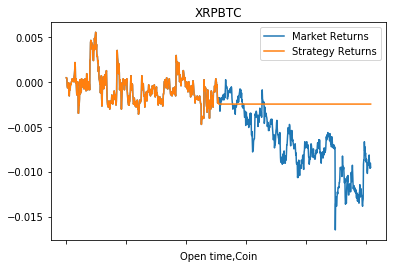

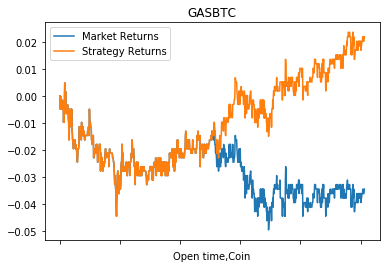

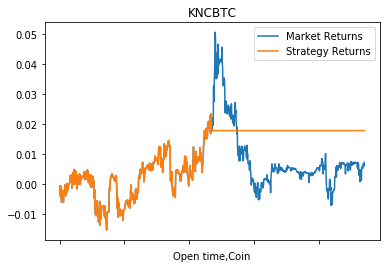

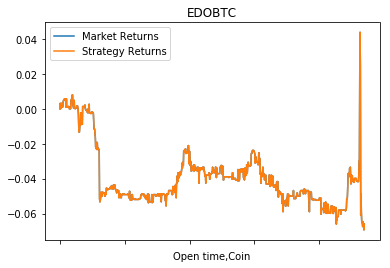

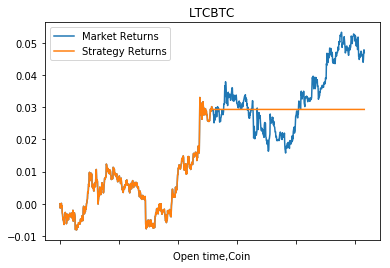

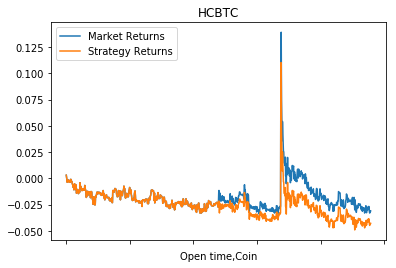

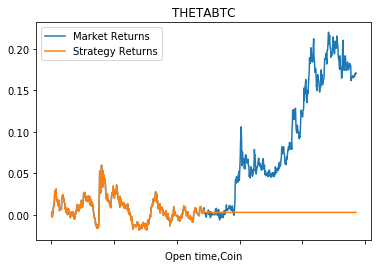

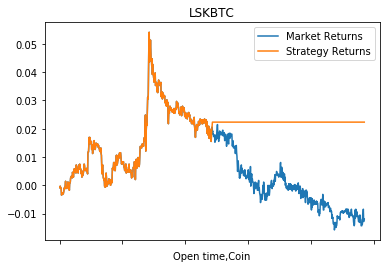

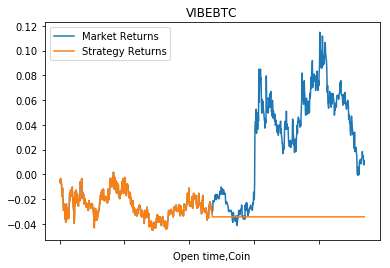

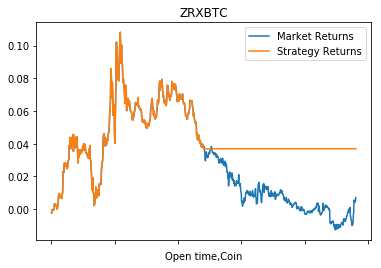

In [7]:
t_rets = {}
t_group = today_port.groupby("Coin")
for t in today.index:
    t_sig = t_group.get_group(t)
    trades = t_sig[["Open","Close","qsig"]].copy()
    trades = trades.fillna(1)
    #print(trades.iloc[int(len(trades)/2)])
    for ct,trade in enumerate(trades.qsig):
        if(trade == -1 and ct != len(trades)-1):
            trades['qsig'].iloc[ct+1:] = 0
            
    
    trades['Market Returns'] = np.log(trades['Close'] / trades['Close'].shift(1))
    trades['Strategy Returns'] = trades['Market Returns'] * trades['qsig'].shift(1)
    trades[['Market Returns','Strategy Returns']].cumsum().plot(title=t)#secondary_y=trades["qsig"])
    t_rets[t] = {'Market Returns':trades["Market Returns"].cumsum().iloc[-1],'Strategy Returns':trades['Strategy Returns'].cumsum().iloc[-1]}
    #print(t_sig[["Open","Close","qsig"]])#.iloc[int(len(t_sig)/2)])


In [8]:
t_rets = pd.DataFrame(t_rets)
print(t_rets)
print("Buy and hold",t_rets.loc['Market Returns'].sum())
print("Strategy: ",t_rets.loc['Strategy Returns'].sum())

                    EDOBTC    GASBTC     HCBTC    KNCBTC    LSKBTC    LTCBTC  \
Market Returns   -0.066079 -0.034458 -0.031165  0.007265 -0.011938  0.047048   
Strategy Returns -0.066079  0.021969 -0.042923  0.017809  0.022328  0.029348   

                  THETABTC   VIBEBTC    XRPBTC    ZRXBTC  
Market Returns    0.170818  0.010920 -0.009518  0.007073  
Strategy Returns  0.002805 -0.034361 -0.002484  0.036920  
Buy and hold 0.08996553212561847
Strategy:  -0.014667996564854194


In [9]:
Buy and hold -0.07574876425990427
Strategy:  0.05686322523613592

SyntaxError: invalid syntax (<ipython-input-9-544031a411eb>, line 2)